### 对AirPassengers数据集进行处理

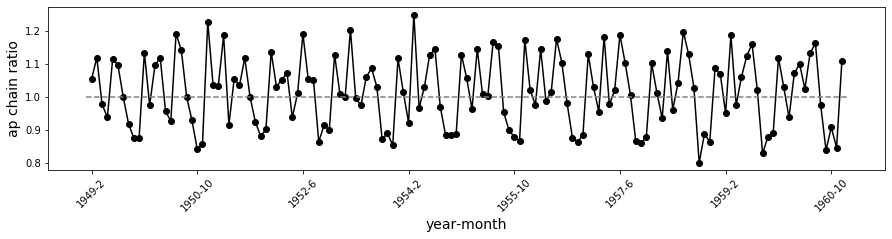

In [1]:
#将AirPassengers数据转换成环比值
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
ap = pd.read_csv("http://image.cador.cn/data/AirPassengers.csv")
ap_chain = ap.passengers[1:ap.shape[0]].values/ap.passengers[0:(ap.shape[0]-1)].values
plt.figure(figsize=(15,3))
plt.plot(range(1,ap.shape[0]),ap_chain,'ko-')
plt.plot([0,ap.shape[0]],[1,1],'--',c='gray')

# 这里+1的原因是，前面计算环比时，错开一位
xindex=[x+1 for x in range(0,ap.shape[0],20)]
plt.xticks(xindex,ap.loc[xindex,:].apply(lambda x:str(x['year'])+'-'+str(x['month']),axis=1).values,rotation=45)
plt.xlabel("year-month",fontsize=14)
plt.ylabel("ap chain ratio",fontsize=14)
plt.show()

### 将环比值按分布区间等分成4份，进行离散化处理

In [2]:
ap_chain_dez = pd.cut(ap_chain,bins=4,include_lowest=True)
ap_chain_lab = pd.cut(ap_chain,bins=4,include_lowest=True,labels=["A","B","C","D"])
out = pd.DataFrame({"dez":ap_chain_dez, "lab":ap_chain_lab, "chain": ap_chain})
out.head()

,dez,lab,chain
0,"(1.025, 1.138]",C,1.053571
1,"(1.025, 1.138]",C,1.118644
2,"(0.913, 1.025]",B,0.977273
3,"(0.913, 1.025]",B,0.937984
4,"(1.025, 1.138]",C,1.115702


### 自定义 arules_parse 函数 

In [3]:
import pandas as pd
def arules_parse(association_results):
    freq_items = list()
    freq_items_support = list()
    left_items = list()
    right_items = list()
    conf = list()
    lift = list()
    rule_support = list()
    for item in association_results:
        freq_items.append(",".join(item[0]))
        freq_items_support.append(item[1])
        for e in item[2]:
            left_items.append(",".join(e[0]))
            right_items.append(",".join(e[1]))
            conf.append(e[2])
            lift.append(e[3])
            rule_support.append(item[1])
    return {
        "freq_items":pd.DataFrame({'items':freq_items, 'support':freq_items_support}),
        "rules":pd.DataFrame({'left':left_items, 'right':right_items,'support':rule_support,'conf':conf,'lift':lift})
    }

### 使用Apriori算法，从中提取可用的规则

In [4]:
import pandas as pd
#构建数据集
winSize=10
con_df = pd.DataFrame([out.lab[i:(i+winSize)].values.tolist() for i in range(ap_chain.shape[0]-winSize+1)],
                      columns=["X"+str(x+1) for x in range(10)])

#由于数据都是按时间先后顺序整理的，因此可用前80%提取规则，用后20%验证规则
con_train = con_df.loc[0:int(con_df.shape[0]*0.8),:]
con_test = con_df.loc[(con_train.shape[0]-1):(con_df.shape[0]-1),:]

#使用Apriori算法，提取关联规则
from apyori import apriori
transactions = con_train.apply(lambda x:(x.index+'='+x.values).tolist(),axis=1).values
association_rules = apriori(transactions, min_support=0.1, 
                            min_confidence=0.5, min_lift=1, min_length=2)  
arules_out = arules_parse(list(association_rules))
display(arules_out['rules'].sort_values('conf',ascending=False).head())

,left,right,support,conf,lift
81,"X9=A,X4=B",X10=A,0.111111,0.923077,4.153846
88,"X8=A,X3=B",X9=A,0.101852,0.916667,4.125000
82,"X6=A,X1=B",X7=A,0.101852,0.916667,4.304348
85,"X7=A,X2=B",X8=A,0.101852,0.916667,4.304348
80,"X10=A,X9=A",X4=B,0.111111,0.857143,2.436090


### 使用 X9=A,X4=B}=>{X10=A} 规则 在验证集con_test上进行验证

In [5]:
tmp = con_test.query("X4=='B' and X9=='A'")
print("%d%%"%(100*sum(tmp["X10"]=='A')/tmp.shape[0]))

100%


### 使用Python中的networkx库来绘制关系网络图

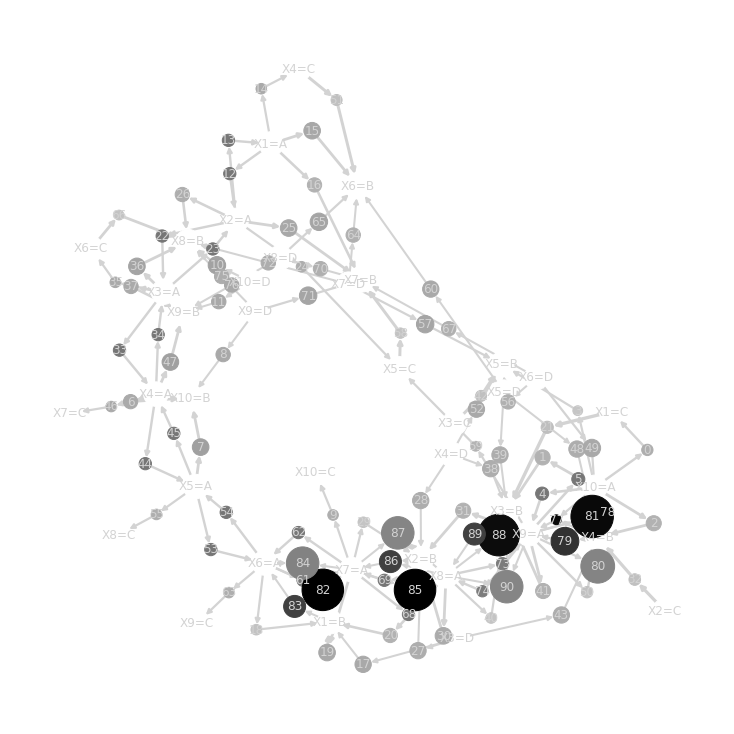

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 声明变量，tuple_list用于存放所有的边，nodes_color，nodes_size分别存放节点的颜色和大小
# edges_size存放边的大小
tuple_list,nodes_color,nodes_size, edges_size= [],{},{},{}
#自定义行处理函数
def row_proc(row):
    tmp_edges = []
    [tmp_edges.append((x,str(row.name))) for x in row['left'].split(",")]
    [tmp_edges.append((str(row.name),x)) for x in row['right'].split(",")]
    for e in row['left'].split(",") + row['right'].split(",") :
        if e not in nodes_color:
            nodes_color[e]=0
            nodes_size[e]=600
    #使用提升度来表示节点的颜色，颜色越深，提升度越大
    nodes_color[str(row.name)]=row['lift']
    #使用置信度来表示节点的大小，节点越大，置信度也就越大
    nodes_size[str(row.name)]=2**(row['conf']*10)*3
    #使用边的大小来表示规则的支持度，边越粗，支持度越大
    for k in tmp_edges:
        edges_size[k]=row['support']*20
    tuple_list.extend(tmp_edges)
    
arules_out['rules'].apply(row_proc,axis=1)
plt.figure(figsize=(10,10))
# 建立有向图
G = nx.DiGraph()
G.add_edges_from(tuple_list)
pos = nx.kamada_kawai_layout(G)
colors = [nodes_color.get(node) for node in G.nodes()]
sizes = [nodes_size.get(node) for node in G.nodes()]
widths =[edges_size.get(edge) for edge in G.edges()]
nx.draw(G, pos,cmap=plt.get_cmap('Greys'),with_labels=True,width=widths,
        node_color=colors,node_size=sizes,edge_color='lightgray',font_color= "lightgray")
plt.show()